<a href="https://colab.research.google.com/github/usnhee/TIL-/blob/master/DL_reuters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = \
reuters.load_data(num_words=10000)

2121728/2110848 [==============================] - 0s 0us/step


### 로이터 뉴스를 46개의 상호배타적 토픽으로 분류 -> 다중분류 
- 46개 토픽 
- 각 토픽은 훈련셋에 최소 10개의 샘플 

In [2]:
print(len(train_data))
print(len(test_data))

8982
2246


In [3]:
print(train_data[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [4]:
print(train_labels[0]) # 인덱스로 0~45 사이의 정수 

3


### 데이터를 벡터로 변환

In [7]:
import numpy as np 

def vectorize_sequences(seqs, dim=10000):
  results = np.zeros((len(seqs), dim))
  for i, seq in enumerate(seqs):
    results[i,seq] = 1. # 특정 인덱스 위치를 1.으로 만듬
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

### 레이블을 벡터로 변환 
### one-hot-encoding이 범주형 데이터에 널리 사용됨. 

In [8]:
def to_one_hot(labels, dim =46): 
  results = np.zeros((len(labels), dim))
  for i, l in enumerate(labels):
    results[i,l] = 1. 
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [9]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성 
- 출력 클래스가 46개 (출력공간 차원이 큼)
- Dense 층을 쌓으면 이전 층의 출력에서 제공한 정보만 사용가능
- 한 층이 분류문제에서 일부 정보를 누락하면 그 다음층에서 이를 복원할 수 없음 -> 각 층은 정보의 bottleneck이 될 수 있다. 
- 중간층은 몇개로 할것인가. 

- 마지막 Dense층 크기: 46 
  - 각 입력 샘플에 대해 46차원 벡터 출력. 이 벡터의 각 원소는 각기 다른 출력 클래스가 인코딩된것. 
- 마지막 층에 softmax 활성화함수 사용 
  - 각 입력 샘플마다 46개 출력 클래스에 대한 확률분포 출력. 46차원 출력벡터를 만들며 output[i]는 어떤 샘플이 클래스i에 속할 확률. 
  - 46개 값 모두 더하면 1 

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이런 문제에 사용할 최선의 손실함수는 
categorical_crossentropy

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

훈련검증 
 - 훈련데이터에서 1000개의 샘플을 따로 떼어 검증셋으로 사용

In [12]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20번의 에포크로 모델 훈련

In [13]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 2s 67ms/step - loss: 2.8556 - accuracy: 0.4974 - val_loss: 1.8673 - val_accuracy: 0.6380
Epoch 2/20
16/16 [==============================] - 1s 50ms/step - loss: 1.4860 - accuracy: 0.7030 - val_loss: 1.3439 - val_accuracy: 0.7080
Epoch 3/20
16/16 [==============================] - 1s 49ms/step - loss: 1.0927 - accuracy: 0.7705 - val_loss: 1.1494 - val_accuracy: 0.7550
Epoch 4/20
16/16 [==============================] - 1s 47ms/step - loss: 0.8563 - accuracy: 0.8227 - val_loss: 1.0409 - val_accuracy: 0.7810
Epoch 5/20
16/16 [==============================] - 1s 48ms/step - loss: 0.6822 - accuracy: 0.8576 - val_loss: 0.9747 - val_accuracy: 0.8040
Epoch 6/20
16/16 [==============================] - 1s 50ms/step - loss: 0.5418 - accuracy: 0.8896 - val_loss: 0.9396 - val_accuracy: 0.8090
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.4390 - accuracy: 0.9127 - val_loss: 0.9043 - val_accuracy: 0.8210
Epoch 8/20
16

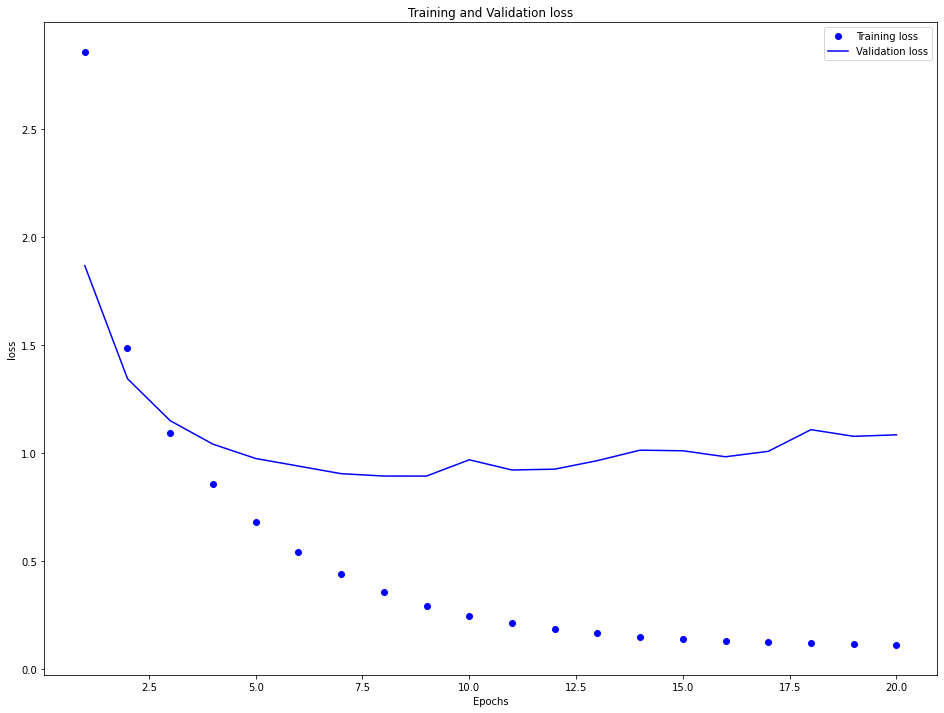

In [14]:
## loss 와 accuracy 곡선을 그려 확인 
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(16,12))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

!!!!accuracy 그래프가 강의안과 다르게 나옴! 위의 loss 그래프랑 똑같게 나옴.. 

<Figure size 432x288 with 0 Axes>

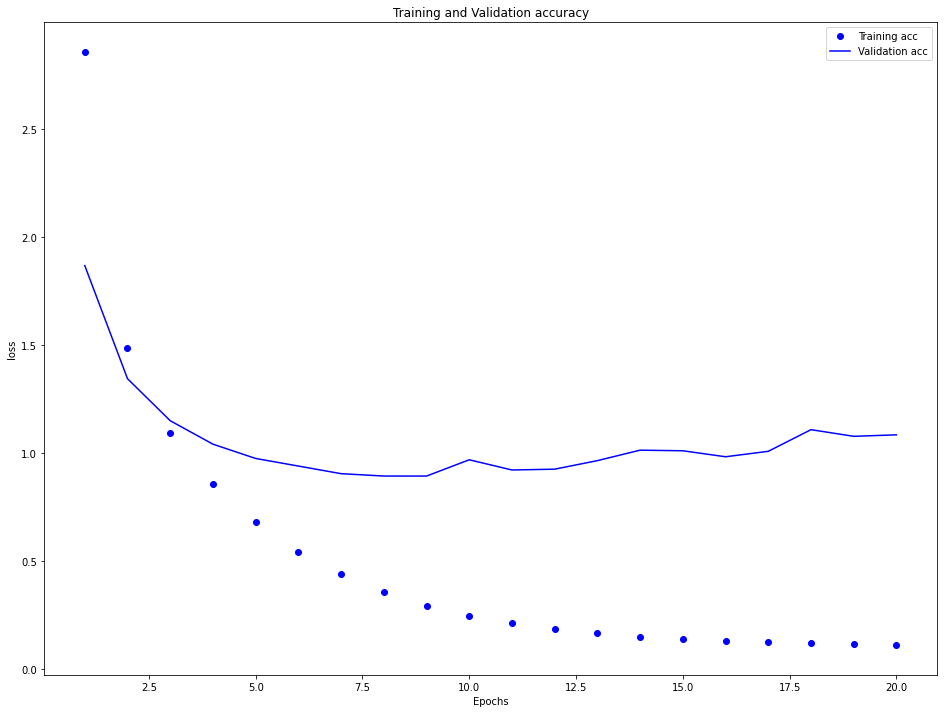

In [18]:
plt.clf()
acc=history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(16,12))
plt.plot(epochs, loss, 'bo', label = 'Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

9번째 epoch에서 과적합 시작
-> 9번의 에포크로 새로운 모델 훈련

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(partial_x_train, partial_y_train, epochs=9, batch_size=512)
results=model.evaluate(x_test, one_hot_test_labels)
print(results)

Epoch 1/9
16/16 [==============================] - 2s 59ms/step - loss: 2.6044 - accuracy: 0.4940
Epoch 2/9
16/16 [==============================] - 1s 55ms/step - loss: 1.4035 - accuracy: 0.7091
Epoch 3/9
16/16 [==============================] - 1s 46ms/step - loss: 1.0287 - accuracy: 0.7808
Epoch 4/9
16/16 [==============================] - 1s 45ms/step - loss: 0.8057 - accuracy: 0.8295
Epoch 5/9
16/16 [==============================] - 1s 44ms/step - loss: 0.6385 - accuracy: 0.8642
Epoch 6/9
16/16 [==============================] - 1s 47ms/step - loss: 0.5088 - accuracy: 0.8959
Epoch 7/9
16/16 [==============================] - 1s 44ms/step - loss: 0.4064 - accuracy: 0.9178
Epoch 8/9
16/16 [==============================] - 1s 46ms/step - loss: 0.3304 - accuracy: 0.9303
Epoch 9/9
71/71 [==============================] - 0s 3ms/step - loss: 1.0003 - accuracy: 0.7894
[1.000284194946289, 0.7894033789634705]


In [22]:
# 새로운 데이터에 대해 예측
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [23]:
np.sum(predictions[0])

0.99999994

In [24]:
np.argmax(predictions[0])

3

충분히 큰 중간층을 두어야 하는 이유 
- 마지막 층이 46차원 
  - 중간층의 히든 유닛이 46보다 많이 작아선 안됨. 